In [1]:
# import modules
import pandas as pd
import numpy as np
import torch
import tensorflow
import matplotlib.pyplot as plt
import pickle
from rdkit import Chem
import os
from utils import masked_aCC, masked_mse, one_hot, RDKfp_convert
datadir = "/Users/yihyun/Code"

2023-05-12 09:14:25.191006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:14:26.546494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546576: W 

In [2]:
# evaluation functions
def masked_aCC(pred, label, mask):
    # multi-output average correlation coefficient with masking
    d_label = (label - np.nansum(label,1)/np.sum(mask, 1))
    d_pred = (pred - np.nansum(pred,1)/np.sum(mask, 1))
    x = np.nansum(np.multiply(d_label,d_pred), 1)
    y = np.sqrt(np.multiply(np.nansum(np.square(d_label), 1) , np.nansum(np.square(d_pred), 1)))
    #aCC = np.mean(x/y)
    return x/y
def masked_mse(pred, label, mask):
    # multi-output mse with masking
    return np.nansum(np.array(pred-label)**2, 1)/np.sum(np.array(mask),1)

def one_hot(vector, n):
    out = np.zeros(n)
    for i in vector:
        out[i] = 1
    return out

def RDKfp_convert(smiles_ls):
    mol_rdkit = list(map(Chem.MolFromSmiles,smiles_ls))
    fps = [list(map(int, list(Chem.RDKFingerprint(x).ToBitString()))) for x in mol_rdkit]
    fps = np.array(fps)
    return fps

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.003s...
[t-SNE] Computed neighbors for 767 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.857069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.354870
[t-SNE] KL divergence after 300 iterations: 0.622224


<AxesSubplot: >

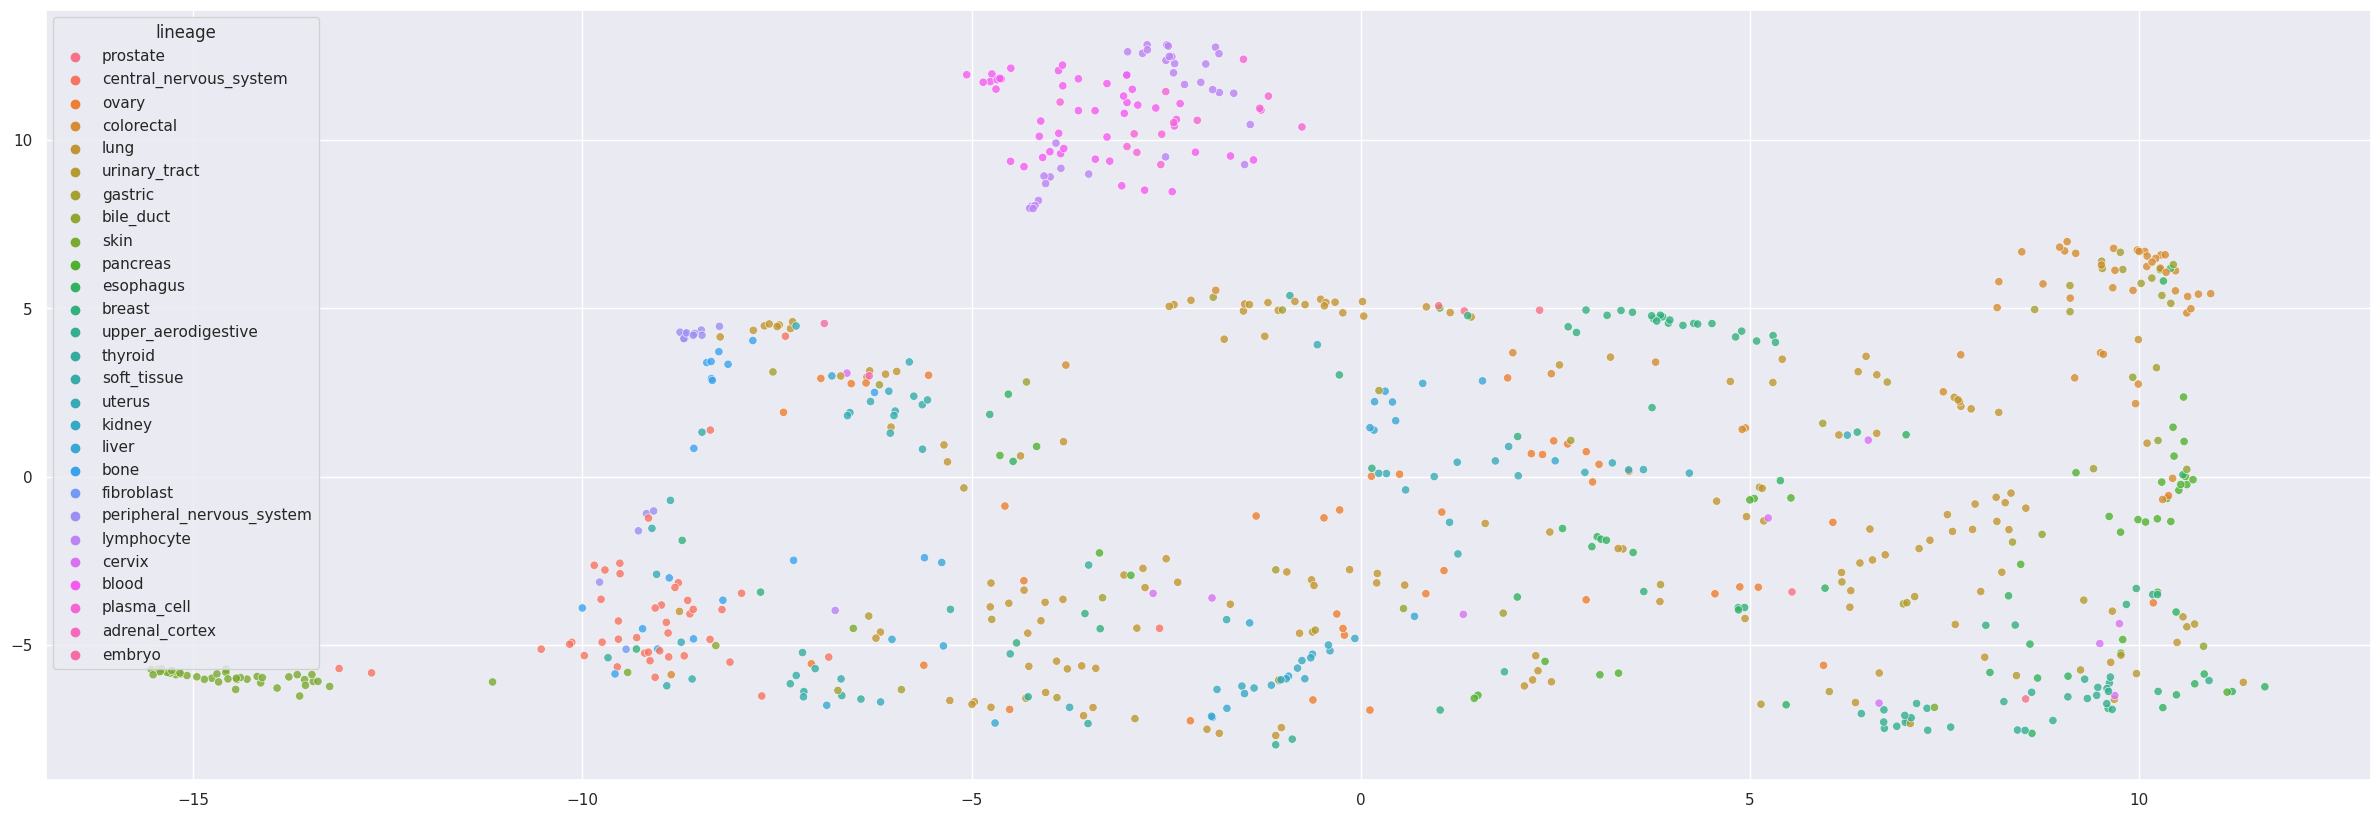

In [12]:
#5-1-1. check the similarity of cell lines in PRISM training set vs. the GDSC dataset and the PRISM disjoint testing set

ccle_kernel = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_1.CaDRReS_CLsim/kernel_cl_train.csv"), index_col=0)
prism_train = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_train.csv"), index_col=0)
prism_both = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_disjoint_test.csv"), index_col=0)
GDSC_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_external_pred.csv"), index_col = 0)

prism_train_kernel = ccle_kernel.loc[prism_train.columns, prism_train.columns]
prism_train_kernel['Split'] = 'PRISM_train'
prism_disjoint_kernel = ccle_kernel.loc[prism_both.columns, prism_train.columns]
prism_disjoint_kernel['Split'] = 'PRISM_test'
GDSC_kernel = ccle_kernel.loc[GDSC_pred.columns, prism_train.columns]
GDSC_kernel['Split'] = 'GDSC_external_test'

kernel_df = pd.concat([prism_train_kernel, prism_disjoint_kernel, GDSC_kernel])

CCLE_info = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/raw/CCLE_sample_info.csv"), index_col=0)
kernel_df["lineage"] = CCLE_info.loc[prism_train.columns.to_list() + prism_both.columns.to_list() + GDSC_pred.columns.to_list(), "lineage"].values

from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X = kernel_df[kernel_df.columns[:-2]]
tsne_results = tsne.fit_transform(X)
#sns.set(rc={"figure.figsize":(30, 10)})
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    #hue="Split",
    hue = "lineage",
    #palette="deep",
    palette=sns.color_palette("husl", 27),
    data=kernel_df,
    #legend="full",
    legend=False,
    alpha=0.8)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1566 samples in 0.002s...
[t-SNE] Computed neighbors for 1566 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1566
[t-SNE] Computed conditional probabilities for sample 1566 / 1566
[t-SNE] Mean sigma: 7.303646
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.020393
[t-SNE] KL divergence after 300 iterations: 1.766216


<AxesSubplot: >

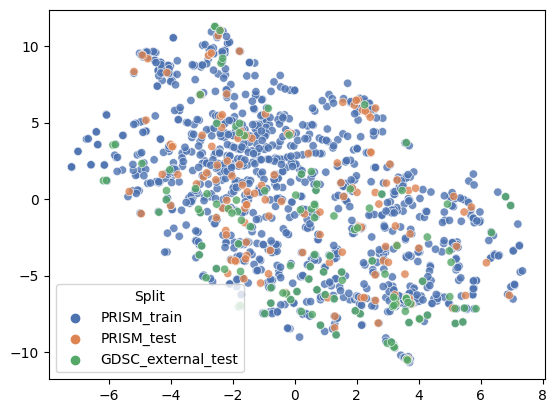

In [137]:
#5-1-2. check the similarity of molecules in the PRISM training set vs. the PRISM disjoint testing set or the GDSC disjoint testing set
prism_train_mol = prism_train.index.to_list()
prism_disjoint_mol = prism_both.index.to_list()
GDSC_mol = GDSC_pred.index.to_list()

feature_name = ["X%d" %(num) for num in range(1, 2049)]
prism_train_fps = pd.DataFrame(RDKfp_convert(prism_train_mol), columns=feature_name)
prism_test_fps = pd.DataFrame(RDKfp_convert(prism_disjoint_mol), columns=feature_name)
GDSC_fps = pd.DataFrame(RDKfp_convert(GDSC_mol), columns=feature_name)

prism_train_fps['Split'] = 'PRISM_train'
prism_test_fps['Split'] = 'PRISM_test'
GDSC_fps['Split'] = 'GDSC_external_test'

fps_df = pd.concat([prism_train_fps, prism_test_fps, GDSC_fps])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X = fps_df[fps_df.columns[:-1]]
tsne_results = tsne.fit_transform(X)
import seaborn as sns
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="Split",
    palette="deep",
    data=fps_df,
    legend="full",
    alpha=0.8)

In [57]:
#5-2. the relationship between the performance and lineage
import pandas as pd
import numpy as np


prism_train = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_train.csv"), index_col=0)
prism_both = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_disjoint_test.csv"), index_col=0)
GDSC_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_external_pred.csv"), index_col = 0)

CCLE_info = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/CCLE_sample_info.csv"), index_col=0)

GDSC2_external_pred = pd.read_csv("/volume/yihyun/drug/GDSC/cadrres_svm_test_external.csv", index_col = 0)
GDSC2_external = pd.read_csv("/volume/yihyun/drug/GDSC/GDSC2_external_IC50.csv", index_col = 0)
GDSC2_external = GDSC2_external[GDSC2_external_pred.columns]
pred_GDSC = 1-np.matrix(GDSC2_external_pred)
mask_GDSC = np.matrix(GDSC2_external.loc[GDSC2_external_pred.index, GDSC2_external_pred.columns].isna(), dtype=int)
label_GDSC = np.matrix(GDSC2_external.loc[GDSC2_external_pred.index, GDSC2_external_pred.columns])


prism_train = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_train.csv", index_col = 'smiles')
prism_both = pd.read_csv("/volume/yihyun/drug/baseline_model/data/prism_disjoint_test.csv", index_col='smiles')
cadrres_svm_pred = pd.read_csv("/volume/yihyun/drug/MF_model/cadrres_svm_test_both.csv", index_col = 0)
pred_cadrres_svm = np.matrix(cadrres_svm_pred)
label_prism = np.matrix(prism_both)
mask_prism = np.matrix(np.isnan(prism_both)==False, dtype=int)

# cell-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for cell_line in GDSC2_external_pred.columns:
    tmp_data = GDSC2_external.loc[GDSC2_external_pred.index, cell_line].dropna()
    tmp_result = GDSC2_external_pred.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)

# evaluation result
PRISM_scc_result = []
for cell_line in cadrres_svm_pred.columns:
    tmp_data = prism_both.loc[cadrres_svm_pred.index, cell_line].dropna()
    tmp_result = cadrres_svm_pred.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    PRISM_scc_result.append(scc)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<BarContainer object of 21 artists>

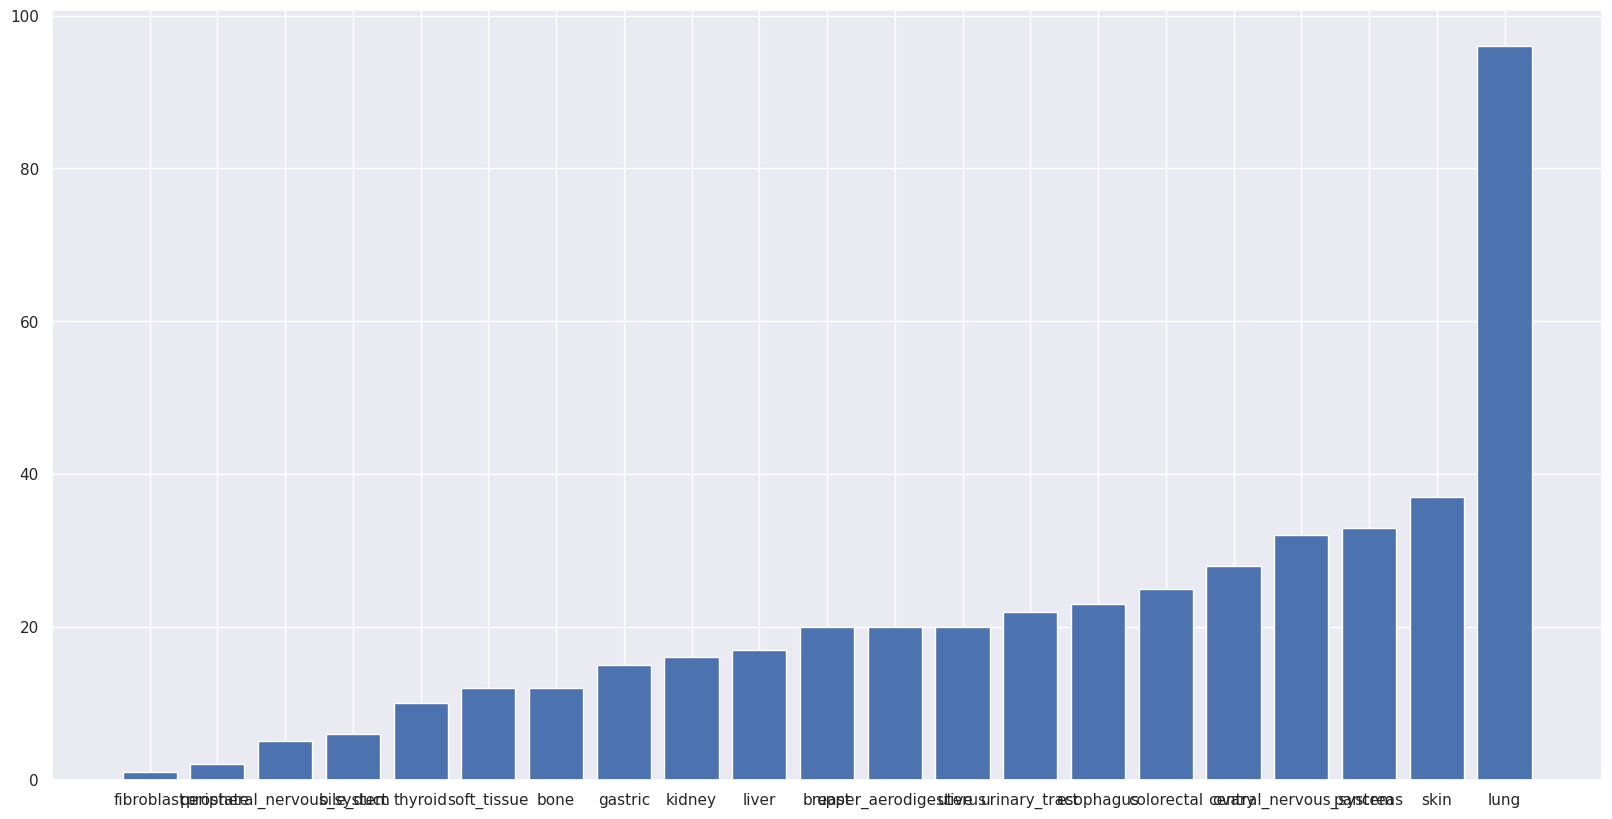

In [15]:
# bar plot of lineage types in training set
from collections import Counter
lineage_type = np.unique(CCLE_info["lineage"])
lineage_type_train_dict = Counter(CCLE_info.loc[prism_train.columns.to_list(), "lineage"].values)
lineage_type_train_dict_sorted = {k:v for k, v in sorted(lineage_type_train_dict.items(), key = lambda kv : kv[1])}


import matplotlib.pyplot as plt
import seaborn as sns
#fig = plt.figure(figsize = (20, 10))
sns.set(rc={"figure.figsize":(20, 10)})
plt.bar(list(lineage_type_train_dict_sorted.keys()), list(lineage_type_train_dict_sorted.values()))

<AxesSubplot: xlabel='lineage', ylabel='SCC'>

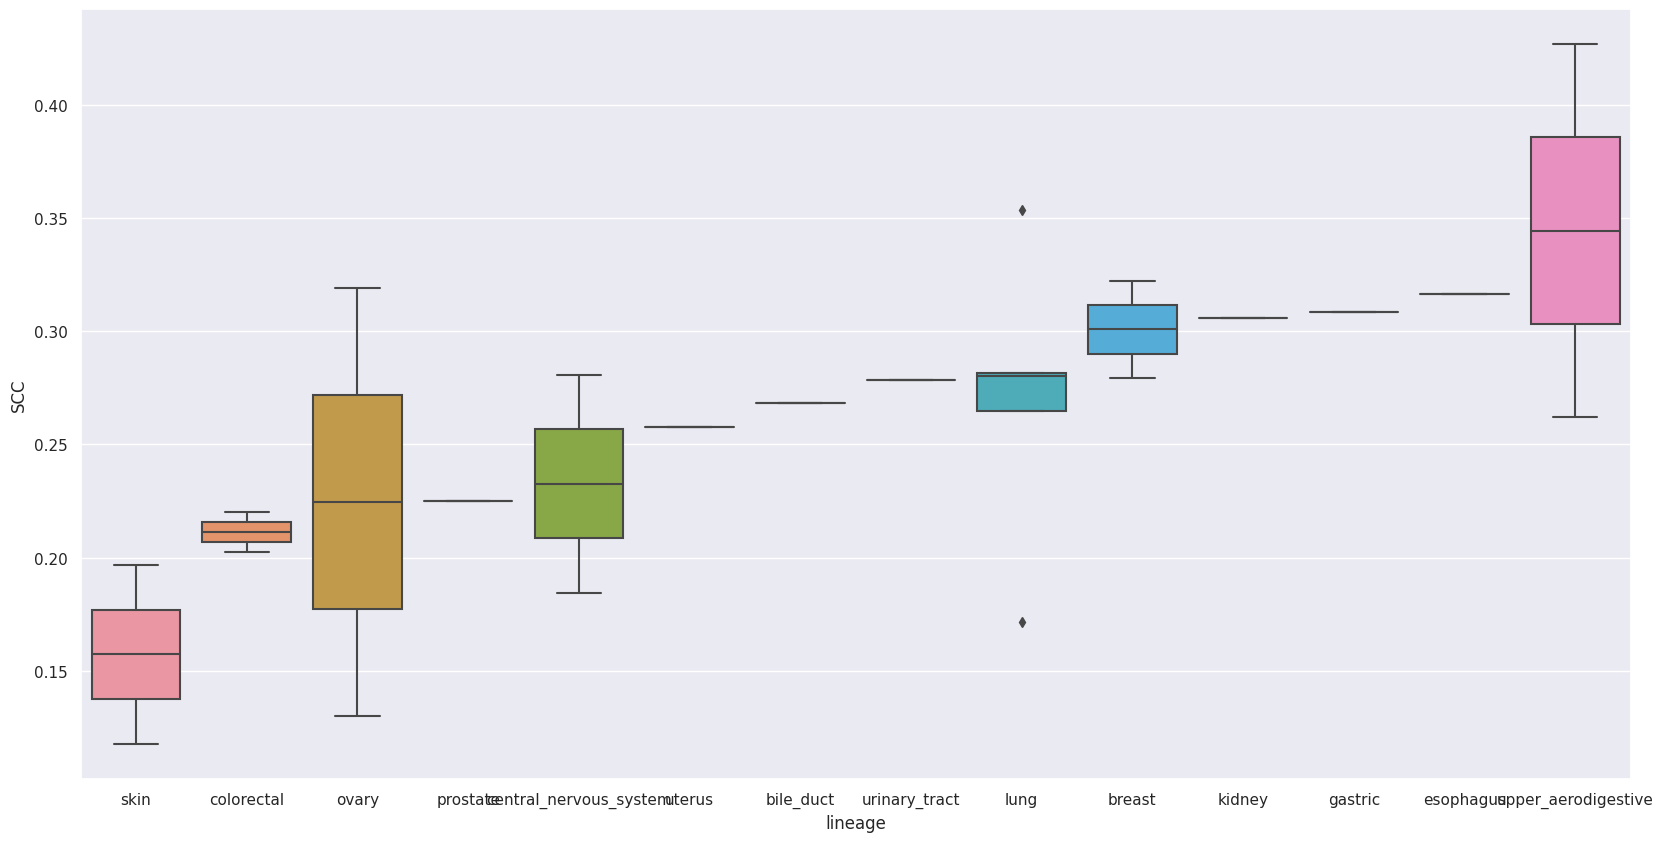

In [69]:
# cell-wise SCC (PRISM disjoint)
disjoint_scc = pd.DataFrame(PRISM_scc_result, columns = ["SCC"])
disjoint_scc["lineage"] = CCLE_info.loc[prism_both.columns.to_list(), "lineage"].values
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)})
median_order = disjoint_scc.groupby(by = ["lineage"])['SCC'].median().sort_values().index
sns.boxplot(data = disjoint_scc, x = "lineage", y = "SCC", order = median_order)


<AxesSubplot: xlabel='lineage', ylabel='SCC'>

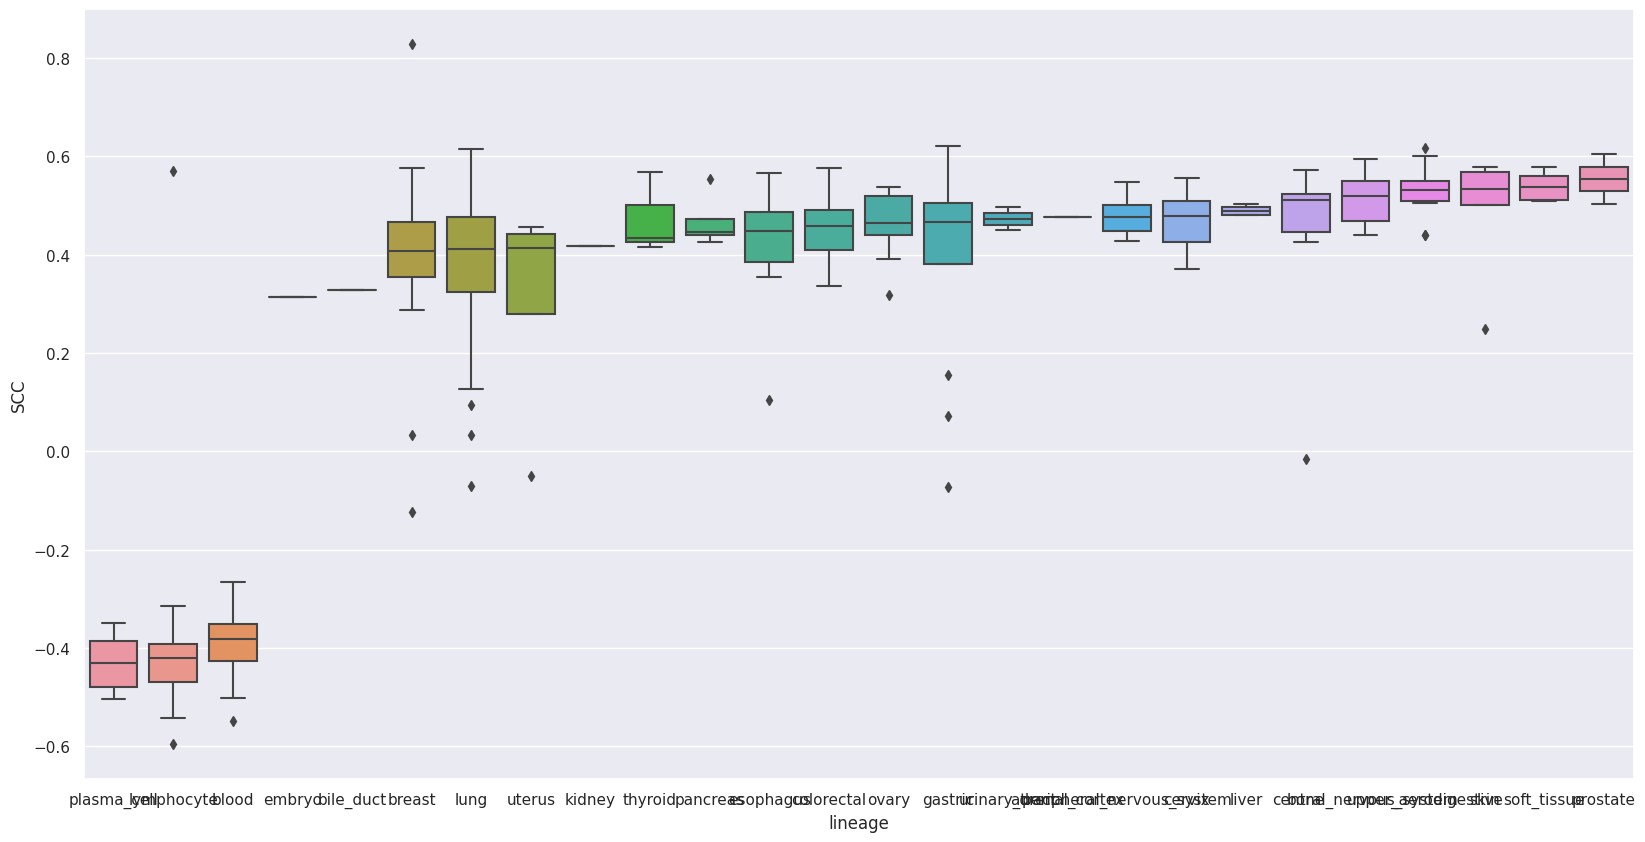

In [31]:
# cell-wise SCC (GDSC)
GDSC_scc = pd.DataFrame(GDSC_scc_result, columns = ["SCC"])
GDSC_scc["lineage"] = CCLE_info.loc[GDSC2_external.columns.to_list(), "lineage"].values
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)})
median_order = GDSC_scc.groupby(by = ["lineage"])['SCC'].median().sort_values().index
sns.boxplot(data = GDSC_scc, x = "lineage", y = "SCC", order = median_order)

<AxesSubplot: xlabel='lineage', ylabel='F1-score'>

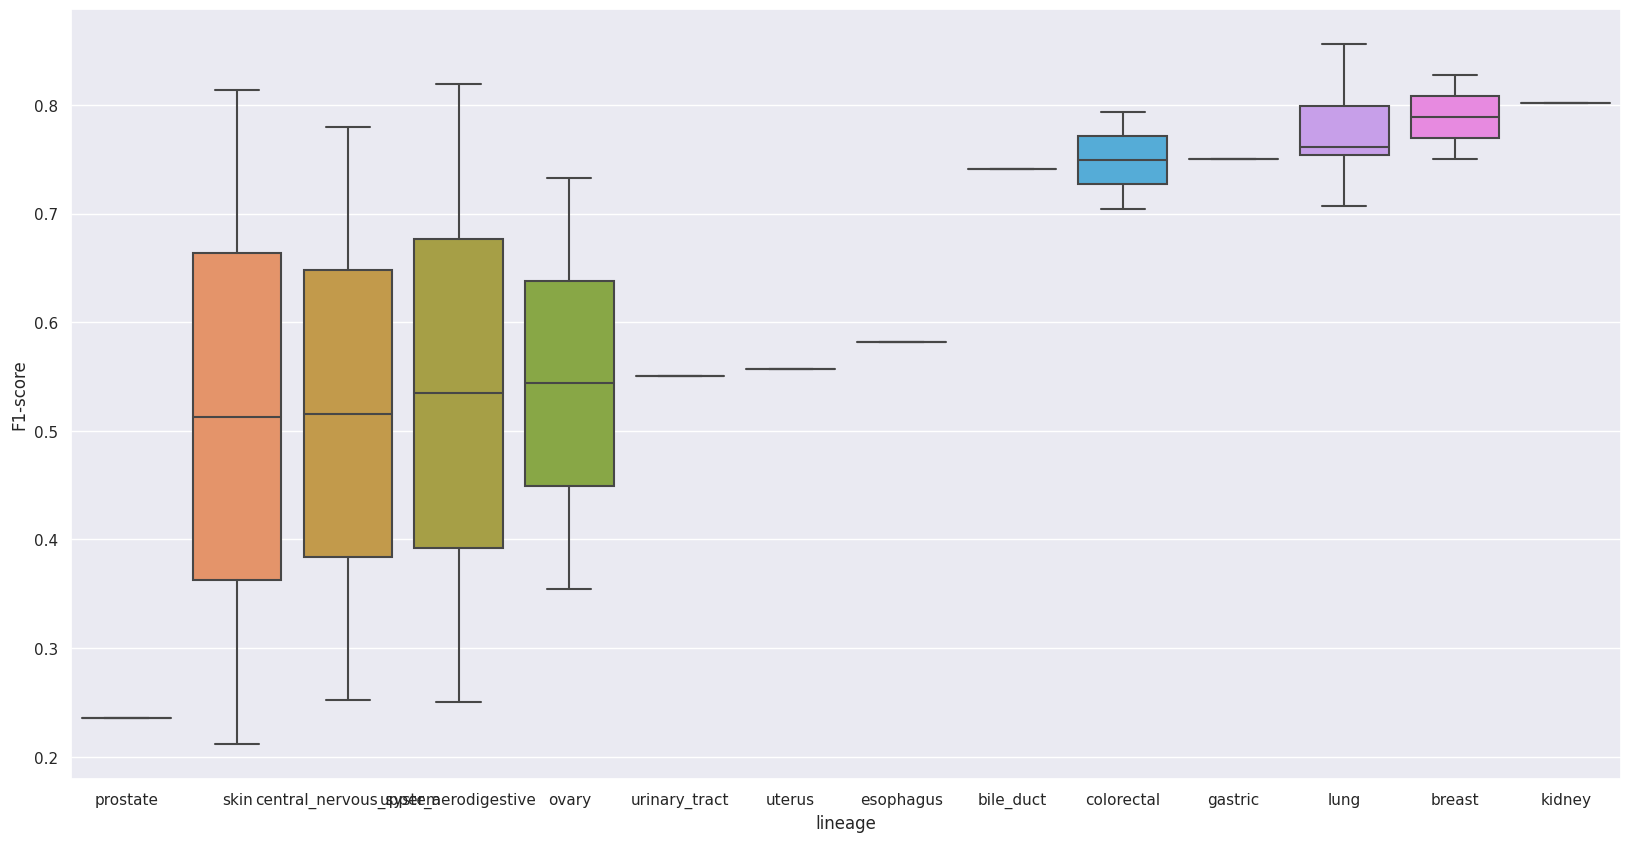

In [32]:
# cell-wise f1 (PRISM disjoint)
disjoint_f1 = pd.DataFrame(prism_f1, columns = ["F1-score"])
disjoint_f1["lineage"] = CCLE_info.loc[prism_both.columns.to_list(), "lineage"].values
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)})
median_order = disjoint_f1.groupby(by = ["lineage"])['F1-score'].median().sort_values().index
sns.boxplot(data = disjoint_f1, x = "lineage", y = "F1-score", order = median_order)

<AxesSubplot: xlabel='lineage', ylabel='F1-score'>

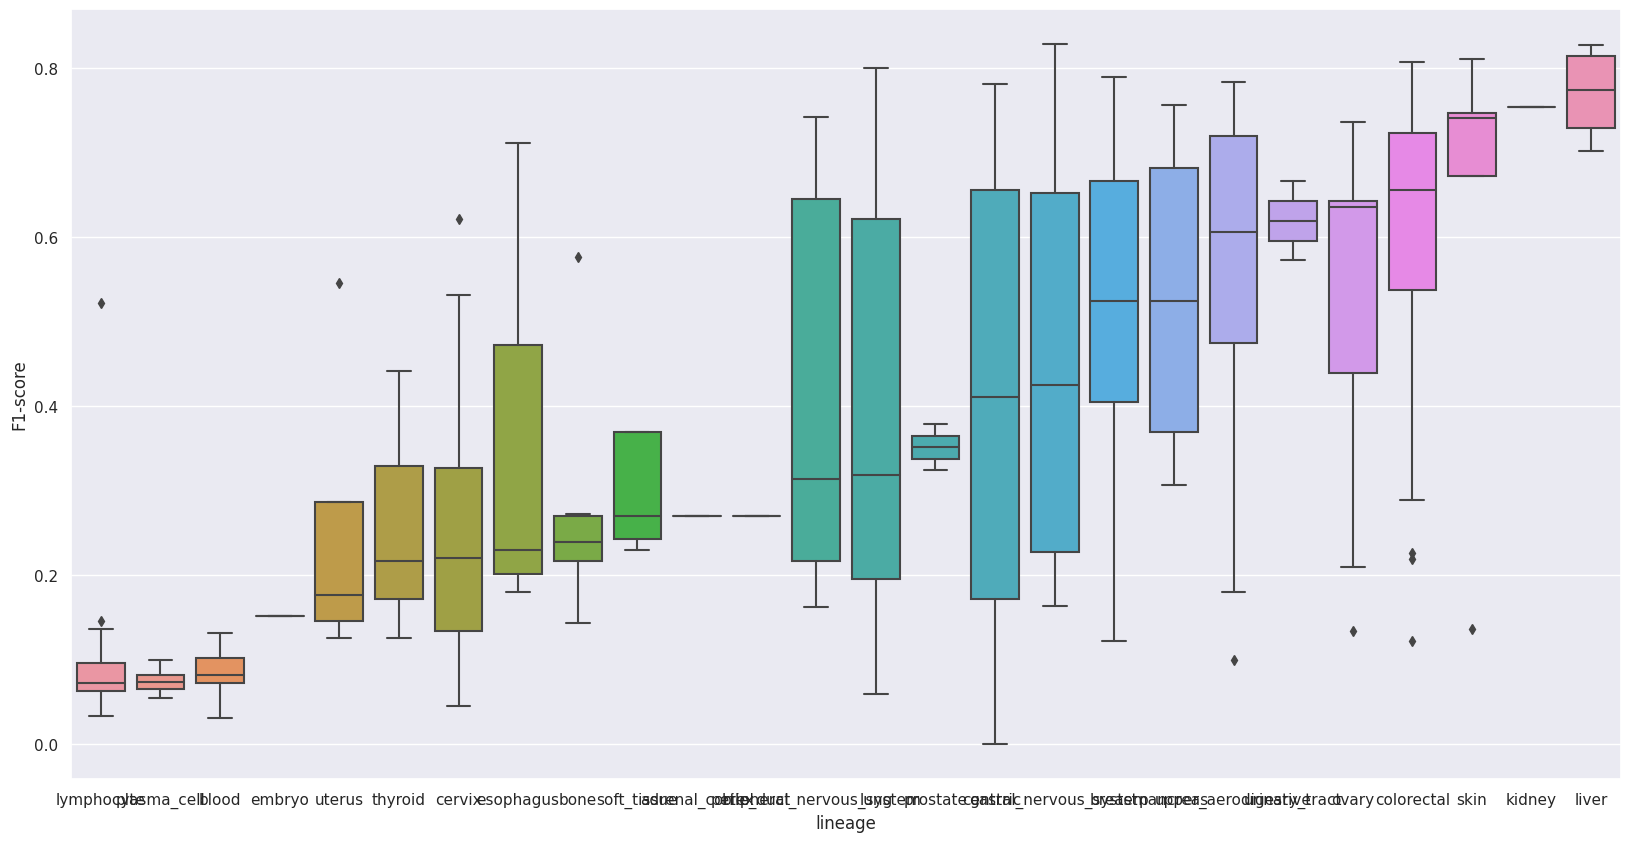

In [68]:
# cell-wise f1 (GDSC)
GDSC2_external = pd.read_csv("/volume/yihyun/drug/GDSC/GDSC2_external_auc.csv", index_col = 0)
GDSC2_external = GDSC2_external[GDSC2_external_pred.columns]
GDSC_f1_df = pd.DataFrame(GDSC_f1, columns = ["F1-score"])
GDSC_f1_df["lineage"] = CCLE_info.loc[GDSC2_external.columns.to_list(), "lineage"].values
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)})
median_order = GDSC_f1_df.groupby(by = ["lineage"])['F1-score'].median().sort_values().index
sns.boxplot(data = GDSC_f1_df, x = "lineage", y = "F1-score", order = median_order, color=median_order)